In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [3]:
# Takes in year and returns the last 2 digits that represent its year
# Examples:
# 2013 -> '13'
# 1999 -> '99'
# 2001 -> '01'
def get_last_year_digits(year):
    return str(year)[-2:]

In [4]:
# Create their respective folders if they're not there
if (not os.path.isdir('html-table')):
    os.mkdir('html-table')
if (not os.path.isdir('csv')):
    os.mkdir('csv')

## Preparing Data

### Regular Season

In [14]:
if (not os.path.isdir('html-table/regseason')):
    os.mkdir('html-table/regseason')
if (not os.path.isdir('csv/regseason')):
    os.mkdir('csv/regseason')

In [6]:
# Extract HTML table of data from raw files
for year in range (1998, 2022 + 1):
    season_year_end = get_last_year_digits(year)
    season_year_start = get_last_year_digits(year - 1)
    
    team_stats_file = open(f'html-raw/regseason/{season_year_start}_{season_year_end}.html')
    team_stats_html = BeautifulSoup(team_stats_file)
    team_stats_table = team_stats_html.body.table
    team_stats_table_file = open(f'html-table/regseason/{season_year_start}_{season_year_end}.html', 'w')
    team_stats_table_file.write(str(team_stats_table))
    team_stats_table_file.close()

In [7]:
# Put the HTML table data into csv files
for year in range(1998, 2022 + 1):
    season_year_end = get_last_year_digits(year)
    season_year_start = get_last_year_digits(year - 1)
    
    table_file = open(f'html-table/regseason/{season_year_start}_{season_year_end}.html')
    table_html = BeautifulSoup(table_file)
    headers = []
    data = []
    for th in table_html.find('tr').find_all('th')[1:15]:
        headers.append(th.text.strip())
    # print(headers)
    for tr in table_html.find_all('tr')[1:]:
        row = []
        for td in tr.find_all('td')[1:]:
            row.append(td.text.strip())
        # print(row)
        data.append(row)
    df = pd.DataFrame(data, columns = headers)
    df['MIN'] = df['MIN'].str.replace(',', '') # Removes the comma that would ordinarily be in these values, pandas automatically corrects the type from str to int
    
    df.columns = df.columns.str.replace(' ', '')
    df.columns = df.columns.str.replace('\u00A0', '') # For whatever reason, the NBA's table uses a different unicode character from the regular "basic space"
    
    df.sort_values(by = 'WIN%', ascending = False)
    df.to_csv(f'csv/regseason/{season_year_start}_{season_year_end}.csv', index = False)

In [15]:
table = pd.read_csv('csv/regseason/21_22.csv')
calc_cols = ['eFG%', 'FTARate', 'TOV%', 'OREB%', 'OppeFG%', 'OppFTARate', 'OppTOV%', 'OppOREB%']
for col in calc_cols:
    mean = table[col].mean()
    std = table[col].std()
    new_col = 'Rel' + col
    table[new_col] = (table[col] - mean) / std # Technically, I'm calculating z-scores on a non-normal curve, but I don't care
# table.sort_values(by = 'TOV%', ascending = True)

In [16]:
xpoints = list(range(1, 31))
xpoints.reverse()
# Generating x-values for rankings

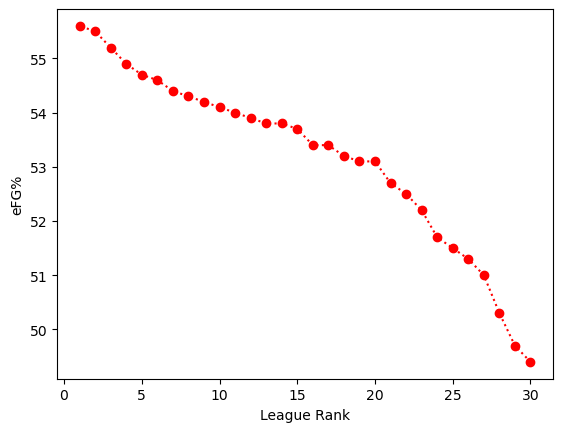

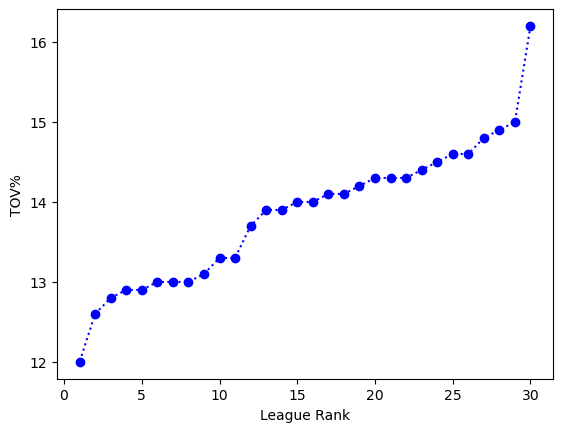

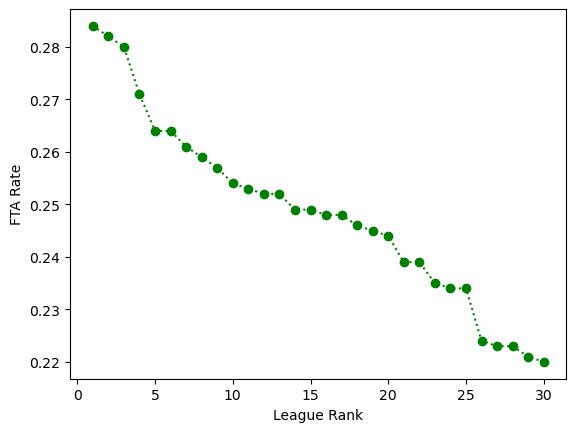

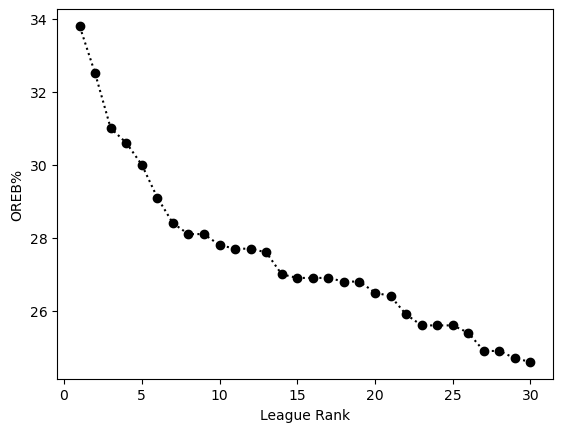

In [17]:
# Offensive Rankings
efg_points = table['eFG%'].sort_values(ascending = True)
tov_points = table['TOV%'].sort_values(ascending = False)
# The best teams turn the ball over less, so you reverse this one for a more accurate view at who is good at mitigating TOs.
fta_points = table['FTARate'].sort_values(ascending = True)
oreb_points = table['OREB%'].sort_values(ascending = True)
plt.plot(xpoints, efg_points, 'o:r')
plt.xlabel('League Rank')
plt.ylabel('eFG%')
plt.show()
plt.plot(xpoints, tov_points, 'o:b')
plt.xlabel('League Rank')
plt.ylabel('TOV%')
plt.show()
plt.plot(xpoints, fta_points, 'o:g')
plt.xlabel('League Rank')
plt.ylabel('FTA Rate')
plt.show()
plt.plot(xpoints, oreb_points, 'o:k')
plt.xlabel('League Rank')
plt.ylabel('OREB%')
plt.show()

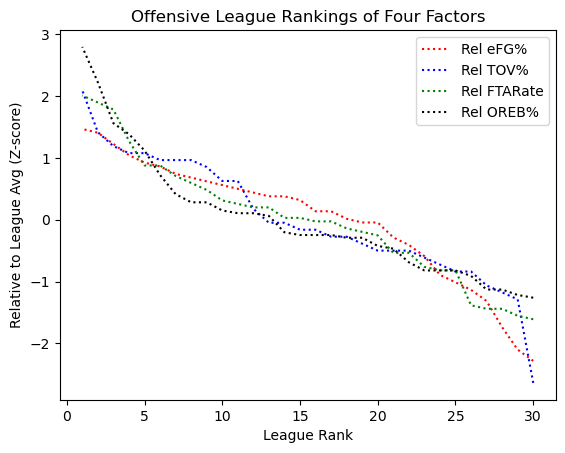

In [18]:
# red = eFG%
# blue = TOV%
# green = FTA Rate
# black = OREB%
rel_efg_points = table['ReleFG%'].sort_values(ascending = True)
rel_tov_points = table['RelTOV%'].mul(-1).sort_values(ascending = True)
# Multiplying the z-score by -1 so that the teams w/ the greatest TOV% have the worse z-score
rel_fta_points = table['RelFTARate'].sort_values(ascending = True)
rel_oreb_points = table['RelOREB%'].sort_values(ascending = True)
plt.plot(xpoints, rel_efg_points, ':r', label = 'Rel eFG%')
plt.plot(xpoints, rel_tov_points, ':b', label = 'Rel TOV%')
plt.plot(xpoints, rel_fta_points, ':g', label = 'Rel FTARate')
plt.plot(xpoints, rel_oreb_points, ':k', label = 'Rel OREB%')
plt.title('Offensive League Rankings of Four Factors')
plt.xlabel('League Rank')
plt.ylabel('Relative to League Avg (Z-score)')
plt.legend()
plt.show()

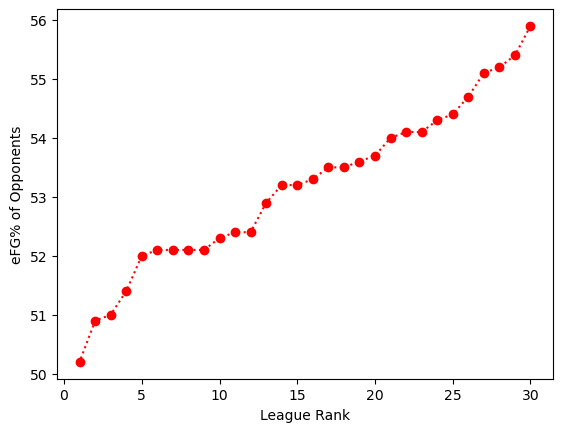

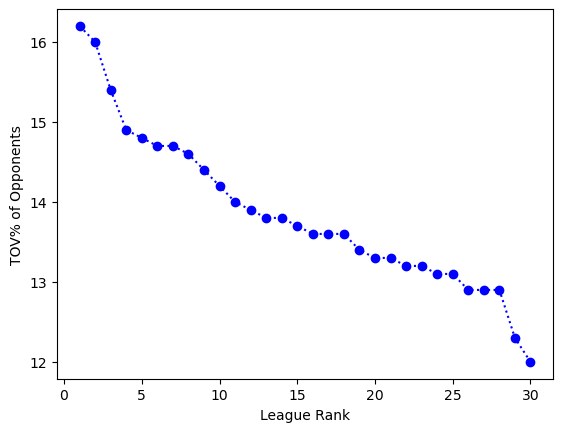

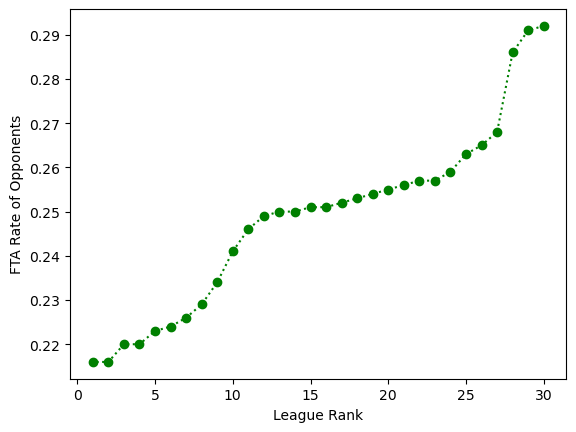

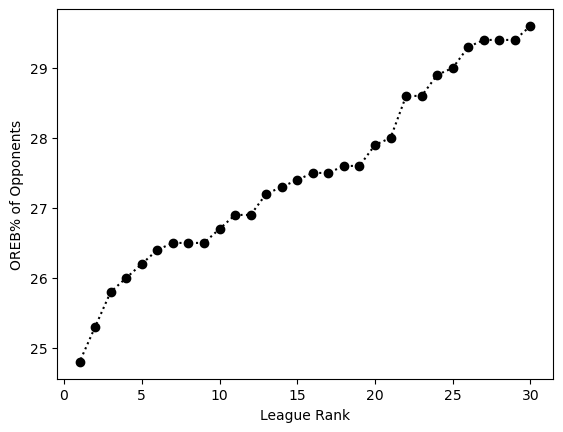

In [19]:
# Defensive Rankings
opp_efg_points = table['OppeFG%'].sort_values(ascending = False)
opp_tov_points = table['OppTOV%'].sort_values(ascending = True)
opp_fta_points = table['OppFTARate'].sort_values(ascending = False)
opp_oreb_points = table['OppOREB%'].sort_values(ascending = False)
plt.plot(xpoints, opp_efg_points, 'o:r')
plt.xlabel('League Rank')
plt.ylabel('eFG% of Opponents')
plt.show()
plt.plot(xpoints, opp_tov_points, 'o:b')
plt.xlabel('League Rank')
plt.ylabel('TOV% of Opponents')
plt.show()
plt.plot(xpoints, opp_fta_points, 'o:g')
plt.xlabel('League Rank')
plt.ylabel('FTA Rate of Opponents')
plt.show()
plt.plot(xpoints, opp_oreb_points, 'o:k')
plt.xlabel('League Rank')
plt.ylabel('OREB% of Opponents')
plt.show()

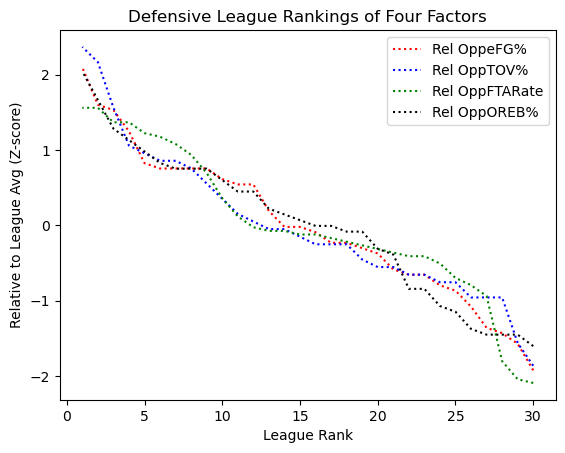

In [20]:
rel_opp_efg_points = table['RelOppeFG%'].mul(-1).sort_values(ascending = True)
rel_opp_fta_points = table['RelOppFTARate'].mul(-1).sort_values(ascending = True)
rel_opp_tov_points = table['RelOppTOV%'].sort_values(ascending = True)
rel_opp_oreb_points = table['RelOppOREB%'].mul(-1).sort_values(ascending = True)

plt.plot(xpoints, rel_opp_efg_points, ':r', label = 'Rel OppeFG%')
plt.plot(xpoints, rel_opp_tov_points, ':b', label = 'Rel OppTOV%')
plt.plot(xpoints, rel_opp_fta_points, ':g', label = 'Rel OppFTARate')
plt.plot(xpoints, rel_opp_oreb_points, ':k', label = 'Rel OppOREB%')

plt.title('Defensive League Rankings of Four Factors')
plt.xlabel('League Rank')
plt.ylabel('Relative to League Avg (Z-score)')
plt.legend()
plt.show()

### Playoffs

In [21]:
if (not os.path.isdir('html-table/playoffs')):
    os.mkdir('html-table/playoffs')
if (not os.path.isdir('csv/playoffs')):
    os.mkdir('csv/playoffs')

In [22]:
# Extract HTML table of data from raw files
for year in range (1998, 2022 + 1):
    season_year_end = get_last_year_digits(year)
    season_year_start = get_last_year_digits(year - 1)
    
    team_stats_file = open(f'html-raw/playoffs/{season_year_start}_{season_year_end}.html')
    team_stats_html = BeautifulSoup(team_stats_file)
    team_stats_table = team_stats_html.find_all('table')[-1]
    
    for i in team_stats_table.find_all('img'): # Removes the images from the graphs
        i.decompose()
    
    team_stats_table_file = open(f'html-table/playoffs/{season_year_start}_{season_year_end}.html', 'w')
    team_stats_table_file.write(str(team_stats_table))
    team_stats_table_file.close()

In [23]:
# Put the HTML table data into csv files
for year in range(1998, 2022 + 1):
    season_year_end = get_last_year_digits(year)
    season_year_start = get_last_year_digits(year - 1)
    
    table_file = open(f'html-table/playoffs/{season_year_start}_{season_year_end}.html')
    table_html = BeautifulSoup(table_file)
    headers = []
    data = []
    for th in table_html.find('tr').find_all('th')[1:28]:
        headers.append(th.text.strip())
    # print(headers)
    for tr in table_html.find_all('tr')[1:]:
        row = []
        for td in tr.find_all('td')[1:]:
            row.append(td.text.strip())
        # print(row)
        data.append(row)
    df = pd.DataFrame(data, columns = headers)
    df['Min'] = df['Min'].str.replace(',', '') # Removes the comma that would ordinarily be in these values, pandas automatically corrects the type from str to int
    df.rename(columns = {'Min': 'MIN'}, inplace=True)
    
    df.columns = df.columns.str.replace(' ', '')
    df.columns = df.columns.str.replace('\u00A0', '') # For whatever reason, the NBA's table uses a different unicode character from the regular "basic space"
    
    df.sort_values(by = 'WIN%', ascending = False)
    df.to_csv(f'csv/playoffs/{season_year_start}_{season_year_end}.csv', index = False)

## Test Merges

In [32]:
playoffs_22 = pd.read_csv('csv/playoffs/21_22.csv')
reg_22 = pd.read_csv('csv/regseason/21_22.csv')

In [34]:
playoffs_wins = playoffs_22[['Team', 'GP', 'W', 'L', 'WIN%']]
playoffs_wins = playoffs_wins.rename(columns={'GP': 'PlayoffGP', 'W': 'PlayoffW', 'L': 'PlayoffL', 'WIN%': 'PlayoffWIN%'})
playoffs_wins

,Team,PlayoffGP,PlayoffW,PlayoffL,PlayoffWIN%
0,Atlanta Hawks,5,1,4,0.200
1,Boston Celtics,24,14,10,0.583
2,Brooklyn Nets,4,0,4,0.000
3,Chicago Bulls,5,1,4,0.200
4,Dallas Mavericks,18,9,9,0.500
5,Denver Nuggets,5,1,4,0.200
6,Golden State Warriors,22,16,6,0.727
7,Memphis Grizzlies,12,6,6,0.500
8,Miami Heat,18,11,7,0.611
9,Milwaukee Bucks,12,7,5,0.583


In [35]:
calc_cols = ['eFG%', 'FTARate', 'TOV%', 'OREB%', 'OppeFG%', 'OppFTARate', 'OppTOV%', 'OppOREB%']
for col in calc_cols:
    mean = reg_22[col].mean()
    std = reg_22[col].std()
    new_col = 'Rel' + col
    reg_22[new_col] = (reg_22[col] - mean) / std # Technically, I'm calculating z-scores on a non-normal curve, but I don't care
rel_cols = ['Rel' + col for col in calc_cols]
# print()
# I should make this into a function

In [36]:
reg_22

,TEAM,GP,W,L,WIN%,MIN,eFG%,FTARate,TOV%,OREB%,...,OppTOV%,OppOREB%,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppOREB%
0,Phoenix Suns,82,64,18,0.780,3946,54.9,0.221,12.9,26.4,...,14.6,27.2,1.044705,-1.553324,-1.077660,-0.467464,-1.530429,0.410242,0.756086,-0.220402
1,Memphis Grizzlies,82,56,26,0.683,3956,52.2,0.245,13.0,33.8,...,14.9,27.4,-0.588907,-0.196051,-0.965012,2.795966,-0.613582,0.217941,1.058521,-0.068401
2,Golden State Warriors,82,53,29,0.646,3946,55.2,0.235,15.0,26.9,...,14.7,26.4,1.226218,-0.761581,1.287935,-0.246962,-1.600956,0.794843,0.856898,-0.828406
3,Miami Heat,82,53,29,0.646,3971,54.7,0.252,14.9,27.8,...,15.4,26.5,0.923697,0.199821,1.175288,0.149941,-0.543056,0.939069,1.562578,-0.752406
4,Dallas Mavericks,82,52,30,0.634,3951,53.8,0.249,13.0,25.6,...,13.6,26.7,0.379159,0.030162,-0.965012,-0.820268,-0.754636,-0.358961,-0.252029,-0.600405
5,Boston Celtics,82,51,31,0.622,3981,54.2,0.239,13.9,27.7,...,14.0,27.5,0.621176,-0.535369,0.048814,0.105841,-2.094643,-0.695488,0.151217,0.007600
6,Milwaukee Bucks,82,51,31,0.622,3951,54.6,0.257,13.3,26.9,...,12.9,25.3,0.863193,0.482586,-0.627070,-0.246962,0.303265,-1.368540,-0.957709,-1.664413
7,Philadelphia 76ers,82,51,31,0.622,3961,53.4,0.282,12.9,24.6,...,13.6,27.6,0.137143,1.896412,-1.077660,-1.261272,-0.543056,0.073715,-0.252029,0.083601
8,Utah Jazz,82,49,33,0.598,3946,55.5,0.271,14.3,30.0,...,12.3,26.2,1.407730,1.274329,0.499403,1.120151,-0.754636,-1.560841,-1.562578,-0.980407
9,Denver Nuggets,82,48,34,0.585,3961,55.6,0.244,14.6,26.8,...,12.9,24.8,1.468234,-0.252604,0.837345,-0.291063,0.373791,0.025640,-0.957709,-2.044415


### Only Playoff Teams

#### Merging Datasets

In [37]:
merge2 = reg_22.merge(playoffs_wins, how='inner', left_on = 'TEAM', right_on = 'Team')
# Inner Join excludes all teams that didn't make the playoffs
merge2 = merge2.drop(columns='Team')
merge2 = merge2.fillna(0)
# Fill in the NaN's so that we can do math with the non-playoff teams
merge2

,TEAM,GP,W,L,WIN%,MIN,eFG%,FTARate,TOV%,OREB%,...,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppOREB%,PlayoffGP,PlayoffW,PlayoffL,PlayoffWIN%
0,Phoenix Suns,82,64,18,0.780,3946,54.9,0.221,12.9,26.4,...,-1.077660,-0.467464,-1.530429,0.410242,0.756086,-0.220402,13,7,6,0.538
1,Memphis Grizzlies,82,56,26,0.683,3956,52.2,0.245,13.0,33.8,...,-0.965012,2.795966,-0.613582,0.217941,1.058521,-0.068401,12,6,6,0.500
2,Golden State Warriors,82,53,29,0.646,3946,55.2,0.235,15.0,26.9,...,1.287935,-0.246962,-1.600956,0.794843,0.856898,-0.828406,22,16,6,0.727
3,Miami Heat,82,53,29,0.646,3971,54.7,0.252,14.9,27.8,...,1.175288,0.149941,-0.543056,0.939069,1.562578,-0.752406,18,11,7,0.611
4,Dallas Mavericks,82,52,30,0.634,3951,53.8,0.249,13.0,25.6,...,-0.965012,-0.820268,-0.754636,-0.358961,-0.252029,-0.600405,18,9,9,0.500
5,Boston Celtics,82,51,31,0.622,3981,54.2,0.239,13.9,27.7,...,0.048814,0.105841,-2.094643,-0.695488,0.151217,0.007600,24,14,10,0.583
6,Milwaukee Bucks,82,51,31,0.622,3951,54.6,0.257,13.3,26.9,...,-0.627070,-0.246962,0.303265,-1.368540,-0.957709,-1.664413,12,7,5,0.583
7,Philadelphia 76ers,82,51,31,0.622,3961,53.4,0.282,12.9,24.6,...,-1.077660,-1.261272,-0.543056,0.073715,-0.252029,0.083601,12,6,6,0.500
8,Utah Jazz,82,49,33,0.598,3946,55.5,0.271,14.3,30.0,...,0.499403,1.120151,-0.754636,-1.560841,-1.562578,-0.980407,6,2,4,0.333
9,Denver Nuggets,82,48,34,0.585,3961,55.6,0.244,14.6,26.8,...,0.837345,-0.291063,0.373791,0.025640,-0.957709,-2.044415,5,1,4,0.200


In [38]:
merge2['Champ%'] = merge2['PlayoffW'] / merge2['PlayoffW'].max()
merge2['PlayoffGP'] = merge2['PlayoffGP'].astype('int64')
merge2['PlayoffW'] = merge2['PlayoffW'].astype('int64')
merge2['PlayoffL'] = merge2['PlayoffL'].astype('int64')

In [39]:
merge2

,TEAM,GP,W,L,WIN%,MIN,eFG%,FTARate,TOV%,OREB%,...,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppOREB%,PlayoffGP,PlayoffW,PlayoffL,PlayoffWIN%,Champ%
0,Phoenix Suns,82,64,18,0.780,3946,54.9,0.221,12.9,26.4,...,-0.467464,-1.530429,0.410242,0.756086,-0.220402,13,7,6,0.538,0.4375
1,Memphis Grizzlies,82,56,26,0.683,3956,52.2,0.245,13.0,33.8,...,2.795966,-0.613582,0.217941,1.058521,-0.068401,12,6,6,0.500,0.3750
2,Golden State Warriors,82,53,29,0.646,3946,55.2,0.235,15.0,26.9,...,-0.246962,-1.600956,0.794843,0.856898,-0.828406,22,16,6,0.727,1.0000
3,Miami Heat,82,53,29,0.646,3971,54.7,0.252,14.9,27.8,...,0.149941,-0.543056,0.939069,1.562578,-0.752406,18,11,7,0.611,0.6875
4,Dallas Mavericks,82,52,30,0.634,3951,53.8,0.249,13.0,25.6,...,-0.820268,-0.754636,-0.358961,-0.252029,-0.600405,18,9,9,0.500,0.5625
5,Boston Celtics,82,51,31,0.622,3981,54.2,0.239,13.9,27.7,...,0.105841,-2.094643,-0.695488,0.151217,0.007600,24,14,10,0.583,0.8750
6,Milwaukee Bucks,82,51,31,0.622,3951,54.6,0.257,13.3,26.9,...,-0.246962,0.303265,-1.368540,-0.957709,-1.664413,12,7,5,0.583,0.4375
7,Philadelphia 76ers,82,51,31,0.622,3961,53.4,0.282,12.9,24.6,...,-1.261272,-0.543056,0.073715,-0.252029,0.083601,12,6,6,0.500,0.3750
8,Utah Jazz,82,49,33,0.598,3946,55.5,0.271,14.3,30.0,...,1.120151,-0.754636,-1.560841,-1.562578,-0.980407,6,2,4,0.333,0.1250
9,Denver Nuggets,82,48,34,0.585,3961,55.6,0.244,14.6,26.8,...,-0.291063,0.373791,0.025640,-0.957709,-2.044415,5,1,4,0.200,0.0625


#### Creating Linear Model

In [40]:
inp, out = merge2[rel_cols], merge2['Champ%']
display(inp), display(out)

,ReleFG%,RelFTARate,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppOREB%
0,1.044705,-1.553324,-1.077660,-0.467464,-1.530429,0.410242,0.756086,-0.220402
1,-0.588907,-0.196051,-0.965012,2.795966,-0.613582,0.217941,1.058521,-0.068401
2,1.226218,-0.761581,1.287935,-0.246962,-1.600956,0.794843,0.856898,-0.828406
3,0.923697,0.199821,1.175288,0.149941,-0.543056,0.939069,1.562578,-0.752406
4,0.379159,0.030162,-0.965012,-0.820268,-0.754636,-0.358961,-0.252029,-0.600405
5,0.621176,-0.535369,0.048814,0.105841,-2.094643,-0.695488,0.151217,0.007600
6,0.863193,0.482586,-0.627070,-0.246962,0.303265,-1.368540,-0.957709,-1.664413
7,0.137143,1.896412,-1.077660,-1.261272,-0.543056,0.073715,-0.252029,0.083601
8,1.407730,1.274329,0.499403,1.120151,-0.754636,-1.560841,-1.562578,-0.980407
9,1.468234,-0.252604,0.837345,-0.291063,0.373791,0.025640,-0.957709,-2.044415


0     0.4375
1     0.3750
2     1.0000
3     0.6875
4     0.5625
5     0.8750
6     0.4375
7     0.3750
8     0.1250
9     0.0625
10    0.1250
11    0.0625
12    0.1250
13    0.0000
14    0.0625
15    0.1250
Name: Champ%, dtype: float64

(None, None)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(inp, out, test_size=0.2)

In [42]:
small_lm1 = LinearRegression()
small_lm1.fit(x_train, y_train)

LinearRegression()

In [43]:
small_lm1.intercept_

0.2518609174741563

In [44]:
list(zip(rel_cols, small_lm1.coef_))

[('ReleFG%', -0.05598889868048393),
 ('RelFTARate', 0.001233257268233657),
 ('RelTOV%', 0.05150489599054935),
 ('RelOREB%', -0.10978909980144855),
 ('RelOppeFG%', -0.2355710869911116),
 ('RelOppFTARate', -0.07399110674911101),
 ('RelOppTOV%', 0.1615972711635416),
 ('RelOppOREB%', -0.1673634044026412)]

In [45]:
y_pred_small_lm1 = small_lm1.predict(x_test)

In [46]:
pd.DataFrame({'Predicted': y_pred_small_lm1, 'Actual': y_test, 'Difference': y_pred_small_lm1 - y_test})

,Predicted,Actual,Difference
3,0.681341,0.6875,-0.006159
9,0.341873,0.0625,0.279373
4,0.535112,0.5625,-0.027388
11,0.151195,0.0625,0.088695


In [47]:
mean_ab_err = metrics.mean_absolute_error(y_test, y_pred_small_lm1)
mean_sq_err = metrics.mean_squared_error(y_test, y_pred_small_lm1)
root_mean_sq_err = np.sqrt(metrics.mean_squared_error(y_test, y_pred_small_lm1))

print('R squared: {:.2f}'.format(small_lm1.score(inp,out)*100))
print('Mean Absolute Error:', mean_ab_err)
print('Mean Square Error:', mean_sq_err)
print('Root Mean Square Error:', root_mean_sq_err)

R squared: 82.83
Mean Absolute Error: 0.10040391668411171
Mean Square Error: 0.021676041692992334
Root Mean Square Error: 0.14722785637572916


### Including Every Team

In [41]:
merge = reg_22.merge(playoffs_wins, how='outer', left_on = 'TEAM', right_on = 'Team')
# Outer Join allows all teams to be included in the data set
merge = merge.drop(columns='Team')
merge = merge.fillna(0)
# Fill in the NaN's so that we can do math with the non-playoff teams
merge

,TEAM,GP,W,L,WIN%,MIN,eFG%,FTARate,TOV%,OREB%,...,RelTOV%,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppOREB%,PlayoffGP,PlayoffW,PlayoffL,PlayoffWIN%
0,Phoenix Suns,82,64,18,0.780,3946,54.9,0.221,12.9,26.4,...,-1.077660,-0.467464,-1.530429,0.410242,0.756086,-0.220402,13.0,7.0,6.0,0.538
1,Memphis Grizzlies,82,56,26,0.683,3956,52.2,0.245,13.0,33.8,...,-0.965012,2.795966,-0.613582,0.217941,1.058521,-0.068401,12.0,6.0,6.0,0.500
2,Golden State Warriors,82,53,29,0.646,3946,55.2,0.235,15.0,26.9,...,1.287935,-0.246962,-1.600956,0.794843,0.856898,-0.828406,22.0,16.0,6.0,0.727
3,Miami Heat,82,53,29,0.646,3971,54.7,0.252,14.9,27.8,...,1.175288,0.149941,-0.543056,0.939069,1.562578,-0.752406,18.0,11.0,7.0,0.611
4,Dallas Mavericks,82,52,30,0.634,3951,53.8,0.249,13.0,25.6,...,-0.965012,-0.820268,-0.754636,-0.358961,-0.252029,-0.600405,18.0,9.0,9.0,0.500
5,Boston Celtics,82,51,31,0.622,3981,54.2,0.239,13.9,27.7,...,0.048814,0.105841,-2.094643,-0.695488,0.151217,0.007600,24.0,14.0,10.0,0.583
6,Milwaukee Bucks,82,51,31,0.622,3951,54.6,0.257,13.3,26.9,...,-0.627070,-0.246962,0.303265,-1.368540,-0.957709,-1.664413,12.0,7.0,5.0,0.583
7,Philadelphia 76ers,82,51,31,0.622,3961,53.4,0.282,12.9,24.6,...,-1.077660,-1.261272,-0.543056,0.073715,-0.252029,0.083601,12.0,6.0,6.0,0.500
8,Utah Jazz,82,49,33,0.598,3946,55.5,0.271,14.3,30.0,...,0.499403,1.120151,-0.754636,-1.560841,-1.562578,-0.980407,6.0,2.0,4.0,0.333
9,Denver Nuggets,82,48,34,0.585,3961,55.6,0.244,14.6,26.8,...,0.837345,-0.291063,0.373791,0.025640,-0.957709,-2.044415,5.0,1.0,4.0,0.200


In [48]:
merge['Champ%'] = merge['PlayoffW'] / merge['PlayoffW'].max()
merge['PlayoffGP'] = merge['PlayoffGP'].astype('int64')
merge['PlayoffW'] = merge['PlayoffW'].astype('int64')
merge['PlayoffL'] = merge['PlayoffL'].astype('int64')

In [44]:
merge.sort_values(by='Champ%', ascending=False)

,TEAM,GP,W,L,WIN%,MIN,eFG%,FTARate,TOV%,OREB%,...,RelOREB%,RelOppeFG%,RelOppFTARate,RelOppTOV%,RelOppOREB%,PlayoffGP,PlayoffW,PlayoffL,PlayoffWIN%,Champ%
2,Golden State Warriors,82,53,29,0.646,3946,55.2,0.235,15.0,26.9,...,-0.246962,-1.600956,0.794843,0.856898,-0.828406,22,16,6,0.727,1.0000
5,Boston Celtics,82,51,31,0.622,3981,54.2,0.239,13.9,27.7,...,0.105841,-2.094643,-0.695488,0.151217,0.007600,24,14,10,0.583,0.8750
3,Miami Heat,82,53,29,0.646,3971,54.7,0.252,14.9,27.8,...,0.149941,-0.543056,0.939069,1.562578,-0.752406,18,11,7,0.611,0.6875
4,Dallas Mavericks,82,52,30,0.634,3951,53.8,0.249,13.0,25.6,...,-0.820268,-0.754636,-0.358961,-0.252029,-0.600405,18,9,9,0.500,0.5625
0,Phoenix Suns,82,64,18,0.780,3946,54.9,0.221,12.9,26.4,...,-0.467464,-1.530429,0.410242,0.756086,-0.220402,13,7,6,0.538,0.4375
6,Milwaukee Bucks,82,51,31,0.622,3951,54.6,0.257,13.3,26.9,...,-0.246962,0.303265,-1.368540,-0.957709,-1.664413,12,7,5,0.583,0.4375
7,Philadelphia 76ers,82,51,31,0.622,3961,53.4,0.282,12.9,24.6,...,-1.261272,-0.543056,0.073715,-0.252029,0.083601,12,6,6,0.500,0.3750
1,Memphis Grizzlies,82,56,26,0.683,3956,52.2,0.245,13.0,33.8,...,2.795966,-0.613582,0.217941,1.058521,-0.068401,12,6,6,0.500,0.3750
12,Minnesota Timberwolves,82,46,36,0.561,3956,53.9,0.254,14.1,28.4,...,0.414544,0.232738,2.044798,2.167447,1.451611,6,2,4,0.333,0.1250
8,Utah Jazz,82,49,33,0.598,3946,55.5,0.271,14.3,30.0,...,1.120151,-0.754636,-1.560841,-1.562578,-0.980407,6,2,4,0.333,0.1250


## Real Analaysis